In [ ]:
conda env export > environment.yml

In [1]:
import os
import re
import string
import unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [2]:
import inflect
from spellchecker import SpellChecker
import csv

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import PerceptronTagger
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer
from nltk.tag import pos_tag


## import datasets

In [64]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
#target = pd.read_csv('train.csv', usecols=['target'])

In [65]:
print(len(df))
print(len(test_df))

7613
3263


In [66]:
test_df.drop(['id'], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)

In [67]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
print(len(test_df))

7503
3243


## visualize target data

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

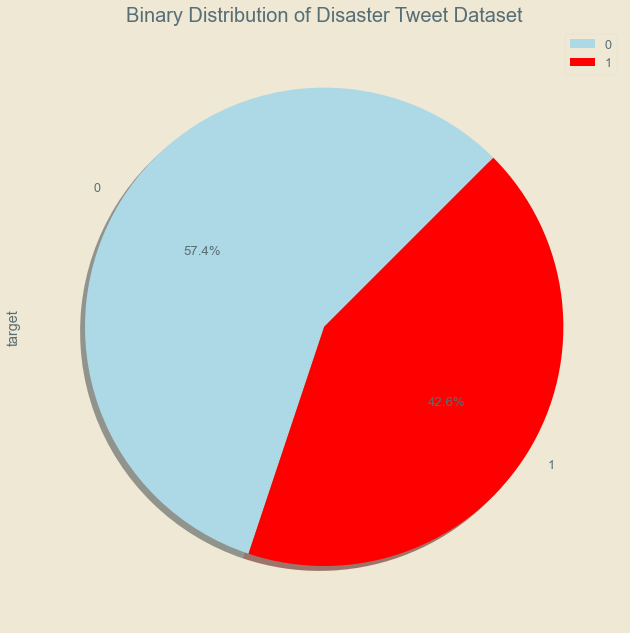

In [68]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [69]:
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
from tqdm import tqdm

## hashtags

In [70]:
def spell_check_words(word):
    # lookup suggestions for multi word string input
    spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    suggestions = spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
    for suggestion in suggestions:
        print(suggestion)   

In [71]:
def spell_check_word(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP)
    for correction in corrections:
        print(correction)

In [72]:
# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)


def remove_non_alpha(text):
    # function to remove non unicode characters from string
    return re.sub('[^a-zA-Z_, ]', '', text)

        
def expand_hashtags(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_hashtag(p_text)
    h_text = remove_hash(lu_text)
    return remove_non_uni(h_text)

def desegment_hashtag(text):
    spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    if text.isupper() | text.islower() and len(text)>= 15:
        result = spell.word_segmentation(text)
        text = result.corrected_string
    return text

def monocase_mask(text):
    # returns boolean mask for monocase strings 
    if text.isupper() | text.islower() and text != 'nan':
        return True

    else:
        return False
    
def mono_check(text):
    # returns boolean mask for monocase strings 
    text.isupper() | text.islower() and text != 'nan'


In [73]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
test_df.hashtags = test_df.hashtags.astype(str)

In [ ]:
expanded_hashtags = df.hashtags.apply(lambda x: (expand_hashtags(x)))
df['expanded_hashtags'] = expanded_hashtags.str.strip()

In [ ]:
#df['expanded_hashtags'] = df.expanded_hashtags.astype(str)
mask = df.expanded_hashtags.apply(lambda x: monocase_mask(x))
df['mc_mask'] = mask

## dictionary based word replacement 

In [76]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [77]:
location_expansion_dict = csv2dict('utils\location_expansion.csv')
contractions_dict = csv2dict('utils\contractions.csv')

In [78]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(r'(?i)'+rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_vowels_mixed_case(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    uvowels = map(lambda x:x.upper(), [x for x in vowels])
    uv = list(uvowels)
    for ch in iter(vowels):
        text = re.sub(rf'([({ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uv):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants_mixed_case(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    uconsonants = map(lambda x:x.upper(), [x for x in consonants])
    uc = list(uconsonants)
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uc):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(r'(?i)'+ rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_ampersands(text):
        # function to remove ampersand and resulting '&amp;amp' string 
    return re.sub(r"&amp?\S*",  r"", text)
    
def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*http\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@\S*",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z_]",  r" ", text)
    
def separate_num_alpha(text):
    # function to remove non alpha chars from string
    return re.sub(r"(?i)(\d)(?=[a-z])|([a-z])(?<=\d)",  r'\1 \2', text)

## tokenize 

In [79]:
def tag_text(text):
    tags = [pos_tag(w)for w in text.split(' ')]
    return tags


def lemmatize_tags(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            token = wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            token = wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            token = wnl.lemmatize(word, pos='a')
        else:
            token = word

        return' '.join(x for x in norm_text(token) if len(x) > 2)
def lemmatize_text(text):
    #function to tokenize and lemmatize text, removing twitter handles and reducing length of words ex. loool = lol
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, 'j', 'v') for w in text.split(' ')]
    new_text = ' '.join(x for x in norm_text(tokens) if len(x) > 2)
    return remove_non_alpha(new_text)


def replace_numbers(tokens):
    # function to replace digits in string with numbers spelled out as words ex 11 = eleven
    dig2word = inflect.engine()
    new_tokens = []
    for word in tokens:
        word = re.sub('(?<=\d),(?=\d)', ' ', word)
        if word.isdigit():
            new_word = dig2word.number_to_words(int(word))
            new_tokens.append(str(new_word))
        else:
            new_tokens.append(word)
    return new_tokens


def remove_non_ascii(tokens):
    # function to remove non unicode characters from tokenized text
    new_tokens = []
    for word in tokens:
        new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_tokens.append(new_token)
    return new_tokens

def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens

def norm_text(tokens):
    # function to normalize text by replacing digits with words and removing stopwords performed on tokenized text
    words = replace_numbers(tokens)
    #new_words = remove_stopwords(words)
    return words

def denoise_text(text):
    text = remove_urls(text)
    text = remove_ampersands(text)
    text = remove_handles(text)
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    text = separate_num_alpha(text)
    return text  

## tweet text process

In [80]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        text = expand_hashtags(text)
        text = word_expansion_from_dict(text, expansion_dict=location_expansion_dict)
        text = word_expansion_from_dict(text.lower(), expansion_dict=contractions_dict)
        return text
    

    def denoise_text(text):
        text = remove_urls(text)
        text = remove_ampersands(text)
        text = remove_handles(text)
        text = reduce_repeat_vowels(text)
        text = reduce_repeat_consonants(text)
        text = separate_num_alpha(text)
        return text      

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text

    
    new_df = [process_text(x) for x in df]

    return new_df 

## keyword text process

In [81]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [82]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_text(text):
        camel_text = expand_hashtags(text) 
        #loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(camel_text, location_expansion_dict)
        return exp_text
    
    def denoise_text(text):
        text = remove_urls(text)
        text = remove_ampersands(text)
        text = remove_handles(text)
        text = reduce_repeat_vowels(text)
        text = reduce_repeat_consonants(text)
        text = separate_num_alpha(text)
        return text  
        
    def process_text(text):
        clean_text = denoise_text(text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text
    
    new_df = [process_text(x) for x in df]
    return new_df 

## create column containing combined column text & tokens columns

In [57]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.str.lower()
    df['tweet_tokens'] = df.tweets.str.lower()
    df['combined_tokens'] = df.combined_tokens.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweet_tokens.apply(lambda row: row.split())
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

# create new dataframe applying above processes

In [ ]:
df['tweets'] = process_tweet(df.text)
test_df['tweets'] = process_tweet(test_df.text)
df['clean_keyword'] = process_keyword(df.keyword.astype(str))
test_df['clean_keyword'] = process_keyword(test_df.keyword.astype(str))
df['clean_location'] = process_location(df.location.astype(str))
test_df['clean_location'] = process_location(test_df.location.astype(str))
pos_train_tags = df['tweets'].apply(lambda row: [nltk.pos_tag(row) for item in row])
pos_test_tags = test_df['tweets'].apply(lambda row: [nltk.pos_tag(row) for item in row])
#pos_keyword_tags = df['keyword'].apply(lambda row: [nltk.pos_tag(row) for item in row])
train_df = combine_columns(df)
test_df2 = combine_columns(test_df)

In [59]:
df

,keyword,location,text,target,hashtags,expanded_hashtags,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,['#earthquake'],earthquake,our deeds the reason this earthquake may allah...,,,our deeds the reason this earthquake may allah...,"[our, deeds, the, reason, this, earthquake, ma...","[our, deeds, the, reason, this, earthquake, ma..."
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],,forest fire near ronge sask canada,,,forest fire near ronge sask canada,"[forest, fire, near, ronge, sask, canada]","[forest, fire, near, ronge, sask, canada]"
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],,all residents ask shelter place notify offic...,,,all residents ask shelter place notify offic...,"[all, residents, ask, shelter, place, notify, ...","[all, residents, ask, shelter, place, notify, ..."
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,['#wildfires'],wildfires,people receive wildfires evacuation ord...,,,people receive wildfires evacuation order cali...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"['#Alaska', '#wildfires']","Alaska, wildfires",just get send this photo from ruby alaska smok...,,,just get send this photo from ruby alaska smok...,"[just, get, send, this, photo, from, ruby, ala...","[just, get, send, this, photo, from, ruby, ala..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7604,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,['#WorldNews'],World News,world news fall powerlines g link tram update...,,,world news fall powerlines g link tram update...,"[world, news, fall, powerlines, g, link, tram,...","[world, news, fall, powerlines, g, link, tram,..."
7605,NaN,NaN,on the flip side I'm at Walmart and there is a...,1,[],,the flip side walmart and there bomb and every...,,,the flip side walmart and there bomb and every...,"[the, flip, side, walmart, and, there, bomb, a...","[the, flip, side, walmart, and, there, bomb, a..."
7606,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,[],,suicide bomber kill fifteen saudi security sit...,,,suicide bomber kill fifteen saudi security sit...,"[suicide, bomber, kill, fifteen, saudi, securi...","[suicide, bomber, kill, fifteen, saudi, securi..."
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,[],,two giant crane hold bridge collapse into near...,,,two giant crane hold bridge collapse into near...,"[two, giant, crane, hold, bridge, collapse, in...","[two, giant, crane, hold, bridge, collapse, in..."


In [60]:
test_df2.to_csv('test_update_nosw.csv')
train_df.to_csv('train_update_nosw.csv')

In [46]:
train_df.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('train samples: ',len(train_df))
test_df2.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('test samples: ',len(test_df2))

train samples:  7489
test samples:  3243


In [61]:
from collections import Counter
word_dict = Counter(train_df.tweet_tokens.sum())
word_dict

Counter({'our': 101,
         'deeds': 2,
         'the': 3297,
         'reason': 31,
         'this': 479,
         'earthquake': 46,
         'may': 89,
         'allah': 7,
         'forgive': 6,
         'all': 280,
         'forest': 66,
         'fire': 346,
         'near': 56,
         'ronge': 1,
         'sask': 1,
         'canada': 15,
         'residents': 8,
         'ask': 32,
         'shelter': 7,
         'place': 32,
         'notify': 1,
         'officers': 1,
         'other': 39,
         'evacuation': 46,
         'order': 40,
         'expect': 30,
         'people': 198,
         'receive': 4,
         'wildfires': 12,
         'california': 138,
         'just': 323,
         'get': 429,
         'send': 52,
         'photo': 44,
         'from': 413,
         'ruby': 2,
         'alaska': 14,
         'smoke': 53,
         'pour': 4,
         'into': 167,
         'school': 69,
         'rocky': 14,
         'update': 52,
         'hwy': 10,
         'twent

In [62]:
len(word_dict)

17159

In [ ]:
print(min(word_dict)[:100])

In [ ]:
test_df[test_df['text'].str.contains("#")]

In [ ]:
train_df[train_df['tweets'].str.contains("cantwaittoplayinminneapolis")]


In [ ]:
df.loc[df['text'].str.contains("&amp")]